In [5]:
import os

from IPython import display
from tqdm.notebook import tqdm
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [209]:
%%bash

bash download-data.bash

In [9]:
# copied from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#visualization-utilities
def show_images(images):
    if not isinstance(images, list):
        images = [images]
    fix, axs = plt.subplots(ncols=len(images), squeeze=False)
    for i, image in enumerate(images):
        image = image.detach()
        image = F.to_pil_image(image)
        axs[0, i].imshow(np.asarray(image))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad = False
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 3221538


In [10]:
# `batch` should be a float tensor with values between 0 and 1
def get_segmentation_logits(model, batch):
    normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    output = model(normalized_batch)['out']
    return output

# `batch_int` should be a uint8 tensor
def show_segmentation(model, batch_int):
    if batch_int.dim() == 3:
        batch_int = batch_int.unsqueeze(0)
    batch = F.convert_image_dtype(batch_int, torch.float32) 
    logits = get_segmentation_logits(model, batch)
    num_classes = logits.shape[1]

    class_dim = 1
    mask_by_class = logits.argmax(1) == torch.arange(num_classes, device=device)[:, None, None, None]
    mask_by_class = einops.rearrange(mask_by_class, 'cls batch w h -> batch cls w h')

    masked_images = [
        torchvision.utils.draw_segmentation_masks(image, masks=mask, alpha=.4)
        # draw_segmentation_masks throws an error on GPU
        for image, mask in zip(batch_int.cpu(), mask_by_class.cpu())
    ]
    show_images(masked_images)

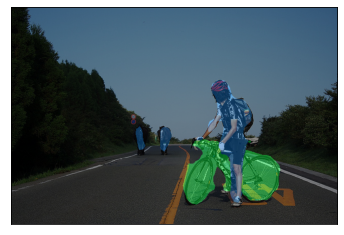

In [13]:
sample_image = torchvision.io.read_image('data/val2017/000000261888.jpg').to(device)
show_segmentation(model, sample_image)

In [14]:
classes = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_index = {class_name: i for (i, class_name) in enumerate(classes)}
background_class_index = class_to_index['background']
person_class_index = class_to_index['person']

In [15]:
data_path = 'data/val2017'
filtered_data_path = 'data/people'
# When we do training to find a perturbation that will hide people, we expect losses 
# to be small for images without people. Let's filter our data to only consider images 
# with people to speed up training.
if not os.path.exists(filtered_data_path):
    os.mkdir(filtered_data_path)
    image_names = os.listdir(data_path)
    for image_name in tqdm(image_names):
        if not image_name.endswith(".jpg"):
            continue
        image_path = os.path.join(data_path, image_name)
        image = torchvision.io.read_image(image_path, mode=torchvision.io.ImageReadMode.RGB).to(device)
        image = F.convert_image_dtype(image, torch.float32)
        with torch.no_grad():
            segmentation = get_segmentation_logits(model, image.unsqueeze(0))
        has_person = person_class_index in segmentation.argmax(1)
        if has_person:
            new_image_path = os.path.join(filtered_data_path, image_name)
            os.symlink(os.path.abspath(image_path), new_image_path)

In [16]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, train):
        self.dir = data_dir
        image_names = os.listdir(self.dir)
        num_images = len(image_names)
        num_train_images = 8 * num_images // 10
        self.image_names = image_names[:num_train_images] if train else image_names[num_train_images:]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.dir, self.image_names[idx])
        image = torchvision.io.read_image(image_path, mode=torchvision.io.ImageReadMode.RGB)
        return image

train_data = CocoDataset(data_dir=filtered_data_path, train=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

In [17]:
# Tiles `tile` to dimensions height-by-width.
def compute_tile(tile, height, width):
    tile_height, tile_width = tile.shape[-2:]
    h_repeat = (height + tile_height - 1) // tile_height
    w_repeat = (width + tile_width - 1) // tile_width
    tiled_result = torch.tile(tile, (h_repeat, w_repeat))
    tiled_result = torch.narrow(tiled_result, -2, 0, height)
    tiled_result = torch.narrow(tiled_result, -1, 0, width)
    return tiled_result
    

class Perturbation(torch.nn.Module):
    def __init__(self, tile_size, max_magnitude):
        super(Perturbation, self).__init__()
        self.perturbation = torch.nn.Parameter(torch.zeros(3, tile_size, tile_size,))
        self.max_magnitude = max_magnitude
        self.clip()
    
    def forward(self, images):
        height, width = images.shape[-2:]
        tiled_perturbation = compute_tile(self.perturbation, height, width)        
        return torch.clamp(images + tiled_perturbation, min=0, max=255)
    
    def clip(self):
        with torch.no_grad():
            self.perturbation.clamp_(min=-self.max_magnitude, max=self.max_magnitude)
            
    def show(self, amplified=False):
        perturbation = self.perturbation.detach().clone()
        if amplified:
            perturbation *= 127.5 / self.max_magnitude
        perturbation += 127.5
        show_images(perturbation.byte())

In [18]:
# The loss function is the cross-entropy loss, except
# - pixels that already match the target class with confidence above 
#   `confidence_threshold` are ignored, and
# - person-classified pixels (relative to `original_segmentation`) are given
#   weight `hiding_weight` and other pixels are given weight `1 - hiding_weight`.
def make_loss_fn(confidence_threshold, hiding_weight):
    cross_entropy_fn = torch.nn.CrossEntropyLoss(reduction='sum')

    def get_misclassified_mask(logits, target):
        probs = logits.softmax(dim=1)
        target_probs = torch.gather(probs, 1, target.unsqueeze(1)).squeeze(1)
        return target_probs < confidence_threshold

    def get_loss_on_mask(logits, target, boolean_mask):
        target = torch.masked_select(target, boolean_mask)
        num_entries = target.shape[0]
        if num_entries == 0:
            return torch.tensor(0., requires_grad=True, device=device)
        logits = torch.masked_select(logits, boolean_mask)
        logits = einops.rearrange(logits, '(cls pixel) -> pixel cls', pixel=num_entries)
        return cross_entropy_fn(logits, target)

    if hiding_weight == 0.5 or hiding_weight is None:
        def loss_fn(logits, target, _person_mask):
            num_pixels = target.numel()
            misclassified = get_misclassified_mask(logits, target)
            logits = einops.rearrange(logits, 'batch cls h w -> cls batch h w')
            total_loss = 0.5 * get_loss_on_mask(logits, target, misclassified) / num_pixels
            return total_loss
    else:
        def loss_fn(logits, target, person_mask):
            num_pixels = target.numel()
            misclassified = get_misclassified_mask(logits, target)
            logits = einops.rearrange(logits, 'batch cls h w -> cls batch h w')
            person_loss = get_loss_on_mask(logits, target, misclassified & person_mask)
            non_person_loss = get_loss_on_mask(logits, target, misclassified & ~person_mask)
            total_loss = (hiding_weight * person_loss + (1 - hiding_weight) * non_person_loss) / num_pixels
            return total_loss

    return loss_fn

In [19]:
class FGSM():  # Fast gradient-sign method
    def __init__(self, params, step_size):
        self.params = list(params)
        self.step_size = step_size
   
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= param.grad.sign() * self.step_size

The following code aims to compute a universal perturbation that hides people from the segmentation model.

In [31]:
perturbation = Perturbation(tile_size=256, max_magnitude=10)
perturbation.to(device)
perturbation_path = "perturbation.pt"
if os.path.exists(perturbation_path):
    perturbation.load_state_dict(torch.load(perturbation_path, map_location=device))

optimizer = FGSM(perturbation.parameters(), step_size=1)
loss_fn = make_loss_fn(confidence_threshold=0.75, hiding_weight=0.9)

In [ ]:
num_epochs = 100
losses = []
num_images = len(train_loader)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    epoch_loss = torch.tensor(0., device=device)
    for batch_int in train_loader: 
        batch_int = batch_int.to(device)
        batch = F.convert_image_dtype(batch_int, torch.float32)
        target = get_segmentation_logits(model, batch).argmax(1)
        person_mask = target == person_class_index
        # For simplicity, for each person-classified pixel, let's make the target class be the
        # background class instead of making it be the same class as the nearest 
        # non-person-classified label. This seems more natural for this data set (as opposed to the
        # Cityscapes data set) anyway since most pixels in this data set are the background class.
        target[person_mask] = background_class_index

        perturbed_batch = perturbation(batch_int)
        logits = get_segmentation_logits(model, perturbed_batch / 255)
        loss = loss_fn(logits, target, person_mask) / num_images
        loss.backward()
        epoch_loss += loss.detach()
        
    optimizer.step()
    perturbation.clip()
    
    print(f'{epoch=} loss={epoch_loss}')
    losses.append(epoch_loss.item())
    plt.plot(losses)
    plt.show()
    display.clear_output(wait=True)
    
    torch.save(perturbation.state_dict(), perturbation_path)

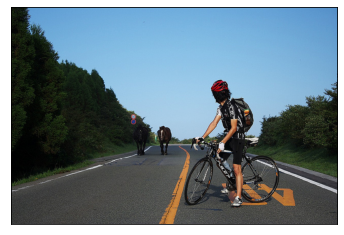

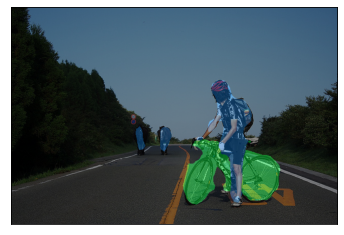

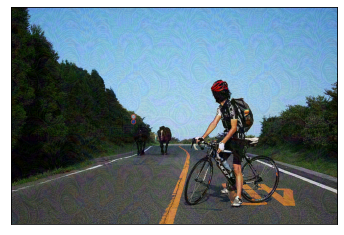

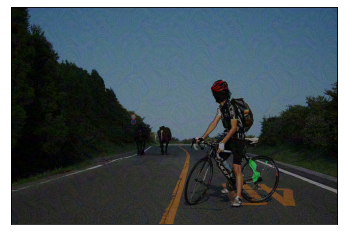

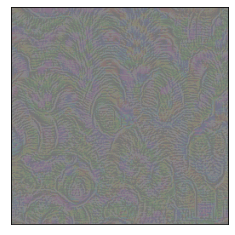

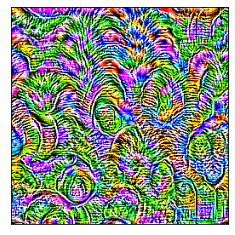

In [22]:
with torch.no_grad():
    perturbed_image = perturbation(sample_image).byte()
    show_images(sample_image)
    show_segmentation(model, sample_image)
    show_images(perturbed_image)
    show_segmentation(model, perturbed_image)
    perturbation.show()
    perturbation.show(amplified=True)

In [29]:
test_data = CocoDataset(data_dir=filtered_data_path, train=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

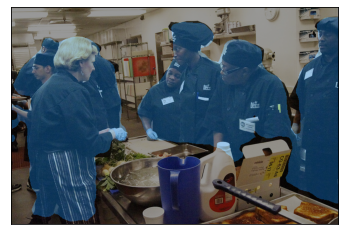

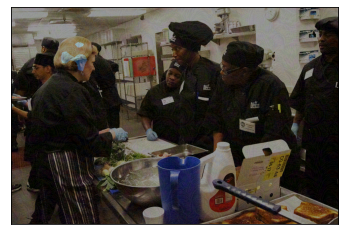

In [41]:
with torch.no_grad():
    batch_int = next(iter(test_loader)).to(device)
    perturbed_image = perturbation(batch_int).byte()
    show_segmentation(model, batch_int)
    show_segmentation(model, perturbed_image)

The following code aims to compute a universal perturbation that makes the segmentation model outputs a static segmentation. The code reuses variable names from previous cells for the training loop, so be careful about overwriting old data.

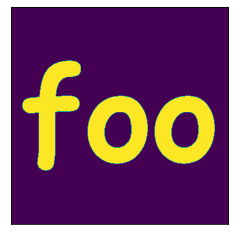

In [24]:
static_target = torchvision.io.read_image(
    'data/static-target.png', 
    mode=torchvision.io.ImageReadMode.GRAY
).to(device)
static_target = static_target < 128
show_images(static_target * 255.)
static_target = (static_target * person_class_index)

In [25]:
perturbation = Perturbation(tile_size=static_target.shape[-1], max_magnitude=10)
perturbation.to(device)
perturbation_path = "static-perturbation.pt"
if os.path.exists(perturbation_path):
    perturbation.load_state_dict(torch.load(perturbation_path, map_location=device))

optimizer = FGSM(perturbation.parameters(), step_size=1)
loss_fn = make_loss_fn(confidence_threshold=0.75, hiding_weight=None)

In [ ]:
num_epochs = 100
losses = []
num_images = len(train_loader)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    epoch_loss = torch.tensor(0., device=device)
    for batch_int in train_loader: 
        batch_int = batch_int.to(device)
        height, width = batch_int.shape[-2:]
        target = compute_tile(static_target, height, width)

        perturbed_batch = perturbation(batch_int)
        logits = get_segmentation_logits(model, perturbed_batch / 255)
        loss = loss_fn(logits, target, None) / num_images
        loss.backward()
        epoch_loss += loss.detach()
        
    optimizer.step()
    perturbation.clip()
    
    print(f'{epoch=} loss={epoch_loss}')
    losses.append(epoch_loss.item())
    plt.plot(losses)
    plt.show()
    display.clear_output(wait=True)
    
    torch.save(perturbation.state_dict(), perturbation_path)

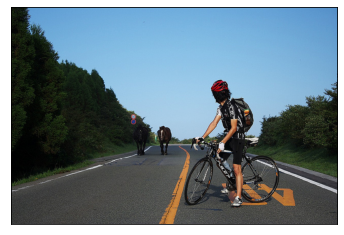

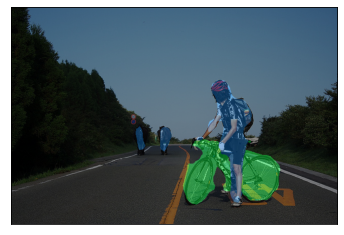

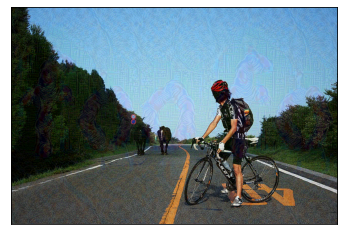

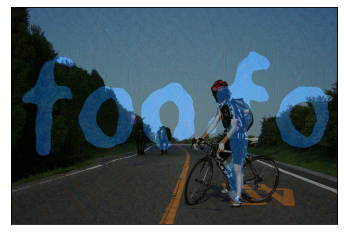

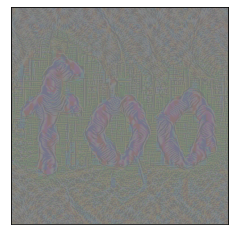

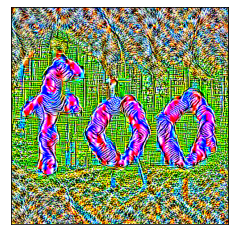

In [27]:
with torch.no_grad():
    perturbed_image = perturbation(sample_image).byte()
    show_images(sample_image)
    show_segmentation(model, sample_image)
    show_images(perturbed_image)
    show_segmentation(model, perturbed_image)
    perturbation.show()
    perturbation.show(amplified=True)

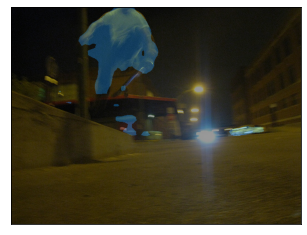

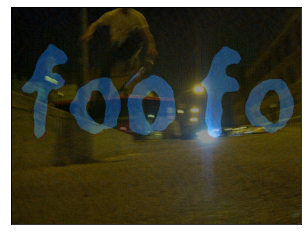

In [30]:
with torch.no_grad():
    batch_int = next(iter(test_loader)).to(device)
    perturbed_image = perturbation(batch_int).byte()
    show_segmentation(model, batch_int)
    show_segmentation(model, perturbed_image)